In [2]:
import pandas as pd
import re
import string
import numpy as np
import matplotlib.pyplot as plt


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")
warnings.resetwarnings()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
pip install scikeras

  Obtaining dependency information for scikeras from https://files.pythonhosted.org/packages/5d/fa/9c1967952e7889d698f10ba8b6af79dfaa2e05178d97a79fbd9d1b44e589/scikeras-0.12.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [4]:
data_news_orig = pd.read_json('/kaggle/input/category-data/News_Category_Dataset_v3.json', lines=True)
#data = pd.read_csv('/content/drive/MyDrive/UOC/tfm/url_classification_data.csv', encoding='utf-8')
data_url_orig = pd.read_csv('/kaggle/input/train-data/url_classification_data_new.csv', encoding='utf-8')


In [5]:
data_train = data_url_orig[pd.notnull(data_url_orig['tokenized_source'])]
data_train = data_train[data_train['category'] != 'None']
data_train = data_train[data_train['category'] != '']
data_train.drop(['url'], axis=1, inplace=True)

data_train = data_train[~data_train['category'].isin(["Calculadora",  "Logout", "Formulario", "Servicios", "Perfil",
                                    "Redes sociales", "Banner"])]

# Seleccionar las columnas "headline" y "category"
data_news = data_news_orig.sample(n=20000, random_state=42)
data_news = data_news[['headline', 'category']]
# Filtrar por las categorias indicadas
categories = ['HEALTHY LIVING','QUEER VOICES','FOOD & DRINK', 'BUSINESS', 'COMEDY', 'SPORTS']
data_news = data_news[data_news['category'].isin(categories)]
# Imprimir el DataFrame con las columnas seleccionadas
data_news = data_news.rename(columns={'headline': 'tokenized_source'})

data = pd.concat([data_train, data_news], axis=0, ignore_index=True)

data = data.dropna(subset=['category'])
data['category'] = data['category'].str.lower()

data.loc[data['category'] == 'validación de literal', 'category'] = 'literal'


#data_literal = data[data['category'] == 'literal'])
#data_not_literal = data[data['category'] != 'literal']

#data = pd.concat([data_literal, data_not_literal], ignore_index=True)


data.head()

,tokenized_source,category
0,errors produits prestació function volver if w...,login
1,errors produits prestació function volver if w...,login
2,errors produits prestació function volver if w...,login
3,errors produits prestació function volver if w...,login
4,errors produits prestació function volver if w...,login


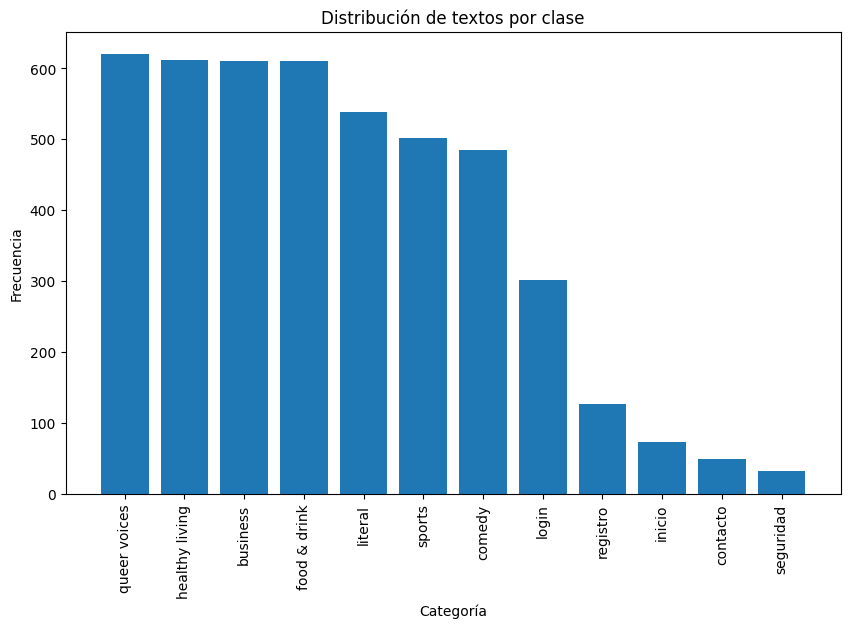

In [6]:
class_counts = data['category'].value_counts()

# Crear un gráfico de barras para visualizar la distribución de textos por clase
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de textos por clase')
plt.xticks(rotation=90)
plt.show()

In [7]:
# Define the list of stopwords for Spanish
stopwords_spanish = set(stopwords.words('spanish'))


def clean_html_data(text):
    # Eliminar saltos de línea
    text = text.replace('\r\n', ' ')
    text = text.replace('\n\n', ' ')
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')

    # Eliminar espacios innecesarios
    text = re.sub('\s\s+', ' ', text)

    # Eliminar caracteres
    #text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'[^\w\sáéíóúÁÉÍÓÚüÜñÑ]', '', text)

    # ELiminar HTML PUBLIC W3CDTD HTML 40 TransitionalEN
    text = text.replace('HTML PUBLIC W3CDTD HTML 40 TransitionalEN', '')
    # Pasar a minusculas
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove storpwords
    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords
    filtered_words = [word for word in words if word.lower() not in stopwords_spanish]

    # Join the filtered words to form the processed text
    processed_text = ' '.join(filtered_words)
    return processed_text

<>:13: DeprecationWarning: invalid escape sequence '\s'
<>:13: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_48/2079241868.py:13: DeprecationWarning: invalid escape sequence '\s'
  text = re.sub('\s\s+', ' ', text)
/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/stopwords/spanish'>
  return concat([self.open(f).read() for f in fileids])


In [8]:
data['tokenized_source'] = data['tokenized_source'].apply(clean_html_data)


In [9]:
# Preprocess the data
X = data['tokenized_source'].values
y = data['category'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Codificar las etiquetas con valores numéricos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


from keras.utils import to_categorical

num_classes =  len(np.unique(y_test_encoded))
y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes)


from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['tokenized_source'])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [10]:
from keras.preprocessing.text import Tokenizer

def tokenization(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer
tokenizer = tokenization(data['tokenized_source'])


In [11]:
import numpy as np

embeddings_index = {}

file_path = "/kaggle/input/glove-data/glove.42B.300d.txt"
f = open(file_path)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(len(embeddings_index))

1917494


In [12]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
from keras.utils import pad_sequences

def encode_sequences(tokenizer, length, lines):
    # Codificar las secuencias con los índices de las palabras
    seq = tokenizer.texts_to_sequences(lines)
    # Hacer el padding
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

from keras.preprocessing.text import Tokenizer

def tokenization(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

from keras.utils import pad_sequences

def encode_sequences(tokenizer, length, lines):
    # Codificar las secuencias con los índices de las palabras
    seq = tokenizer.texts_to_sequences(lines)
    # Hacer el padding
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq



In [14]:

# Codificamos el conjunto de train
max_length = 30
X_train = encode_sequences(tokenizer, max_length, X_train)
X_test = encode_sequences(tokenizer, max_length, X_test)

X_train[:5]

array([[  194,  2769,   332,     9,  6916,   490, 15019,  1801,     9,
          532,    77,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [26405,     9,  3138,  4596,    27,  6920, 14879,  3808,  1419,
        15391,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [   91,  3331,    27,  3328, 24004,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [15711, 27880,   490,  6858,    64,  1859,  4970,   695,     9,
          229, 27881,    66,  3041,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [  501,  9702,  1535,

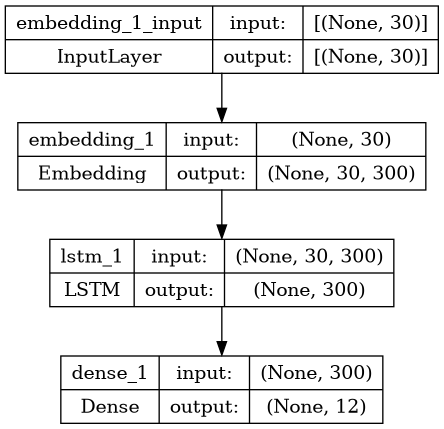

In [26]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.utils import plot_model
from keras.layers import Embedding
from keras import optimizers


embedding_vec_length = 300
max_text_length = 30
units = 300
learning_rate= 0.01
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            embedding_vec_length,
                            weights=[embedding_matrix],
                            input_length=max_text_length,
                            trainable=False,
                            mask_zero=True)

def define_model(embedding_layer,units, out_vocab_size):
    model = Sequential()
    # Embedding
    model.add(embedding_layer)

    # LSTM
    model.add(LSTM(units))

    # Output
    model.add(Dense(out_vocab_size, activation='softmax'))
    return model

model = define_model(embedding_layer, units, num_classes)



adam = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy')

plot_model(model, show_shapes=True, show_layer_names=True)


In [16]:
xxx

NameError: name 'xxx' is not defined

In [27]:

from keras.callbacks import ModelCheckpoint



#La función ModelCheckpoint() guarda el modelo con la pérdida de validación más baja.

checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#Entrenamiento del modelo. Se realiza con 30 epoch con un tamaño de batch de 512, con un reparto de validación del
#20%; esto es, 80% se destina al entrenamiento en sí, y el 20% restante a su validación.

model.fit(X_train, 
          y_train_one_hot,
          epochs=50, 
          batch_size=512,
          callbacks=[checkpoint],
          verbose=1
         )
filename = 'lstm_best_model.h5'
model.save(filename)

Epoch 1/50
8/8 [==============================] - 9s 28ms/step - loss: 1.5023
Epoch 2/50
8/8 [==============================] - 0s 26ms/step - loss: 0.7838
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 0.5917
Epoch 4/50
8/8 [==============================] - 0s 22ms/step - loss: 0.4733
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.3903
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 0.3195
Epoch 7/50
8/8 [==============================] - 0s 22ms/step - loss: 0.2463
Epoch 8/50
8/8 [==============================] - 0s 24ms/step - loss: 0.2136
Epoch 9/50
8/8 [==============================] - 0s 23ms/step - loss: 0.1751
Epoch 10/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1440
Epoch 11/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1394
Epoch 12/50
8/8 [==============================] - 0s 21ms/step - loss: 0.1286
Epoch 13/50
8/8 [==============================] - 0s 21ms/st

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 3ms/step
Accuracy del modelo: 0.7579408543263965
Precision del modelo: 0.7735879587252525
Recall del modelo: 0.7579408543263965
F1 del modelo: 0.7567123902254392
              precision    recall  f1-score   support

           0       0.69      0.76      0.73       120
           1       0.76      0.75      0.75       110
           2       0.67      0.18      0.29        11
           3       0.80      0.90      0.84        96
           4       0.72      0.72      0.72       118
           5       0.77      0.77      0.77        13
           6       0.90      0.61      0.73       114
           7       0.59      0.94      0.72        67
           8       0.87      0.77      0.81       128
           9       0.75      0.80      0.77        30
          10       0.33      0.43      0.38         7
          11       0.84      0.79      0.81        99

    accuracy                           0.76       913
   macro avg       0.72      0.70   

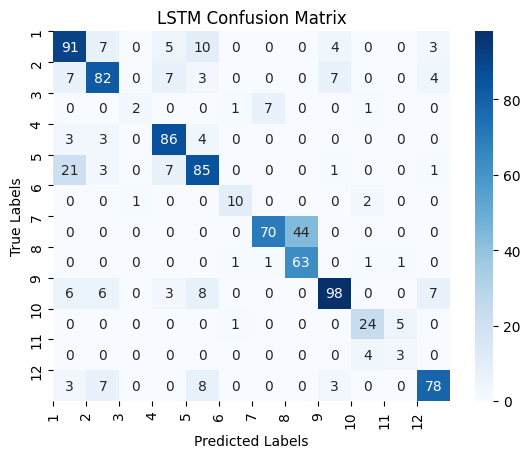

In [30]:
predictions = model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test_one_hot, axis=1)
y_pred = np.argmax(predictions, axis=1)

# Calcular la exactitud (accuracy)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy del modelo:", accuracy)

# Calcular la precisión (precision)
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision del modelo:", precision)

# Calcular la exhaustividad (recall)
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall del modelo:", recall)

# Calcular la puntuación F1
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 del modelo:", f1)

# Generar el informe de clasificación
classification_report_res = classification_report(y_true, y_pred)

print(classification_report_res)


import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Generar la matriz de confusión
confusion_matrix_lstm = confusion_matrix(y_true, y_pred)

# Graficar
sns.heatmap(confusion_matrix_lstm, annot=True, cmap='Blues', fmt='d')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('LSTM Confusion Matrix')
plt.xticks(ticks=np.arange(num_classes), labels=range(1,num_classes + 1), rotation=90)
plt.yticks(ticks=np.arange(num_classes), labels=range(1,num_classes + 1))

plt.show()

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras import optimizers

from tensorflow.keras.callbacks import EarlyStopping

def create_model( embedding_vec_length=300, units=300, learning_rate=0.01):
    print("-----------")
    print("embedding_vec_length", embedding_vec_length)
    print("units", units)
    print("learning_rate", learning_rate)
    print("-----------")
    max_text_length=30
    embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                embedding_vec_length,
                                input_length=max_text_length,
                                trainable=False)

    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(units))

    model.add(Dense(num_classes, activation='softmax'))
    adam = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam, loss='categorical_crossentropy')
    return model

# Create a KerasClassifier with the model building function
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=512,
                        embedding_vec_length=300,
                        learning_rate=0.1,
                        units =300,
                        #max_text_length =[10, 20, 30]
                        )
model.get_params().keys()
# Define the hyperparameters to search
param_grid = {
    'embedding_vec_length': [100, 300, 400],
    #'max_text_length': [10, 20, 28],
    'units': [200, 300],
    'learning_rate': [0.01, 0.1],
}

# Create GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, error_score="raise")
grid_result = grid.fit(X_train,
                       y_train_one_hot,
                       validation_split=0.2,  # Use a validation split
                       callbacks=[early_stopping])  # X_train and y_train are your training data

# Print the best parameters and corresponding accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


## Linear regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create logistic regression model
model = LogisticRegression()

# Define hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'class_weight': [None, 'balanced']
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(Train_X_Tfidf, y_train_encoded)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the model on the validation set
accuracy = best_model.score(X_val, y_val)
print("Validation Accuracy:", accuracy)
# Print the best parameters and corresponding accuracy
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Accuracy: 0.7130339539978094
Classification Report:
                 precision    recall  f1-score   support

      business       0.53      0.51      0.52       120
        comedy       0.65      0.67      0.66       110
      contacto       0.82      0.82      0.82        11
  food & drink       0.64      0.74      0.69        96
healthy living       0.53      0.59      0.56       118
        inicio       0.71      0.77      0.74        13
       literal       1.00      1.00      1.00       114
         login       1.00      0.91      0.95        67
  queer voices       0.87      0.63      0.73       128
      registro       0.86      0.83      0.85        30
     seguridad       0.50      0.86      0.63         7
        sports       0.65      0.70      0.67        99

      accuracy                           0.71       913
     macro avg       0.73      0.75      0.74       913
  weighted avg       0.73      0.71      0.72       913



([<matplotlib.axis.YTick at 0x7a30b408b9d0>,
 [Text(0, 0, '1'),
  Text(0, 1, '2'),
  Text(0, 2, '3'),
  Text(0, 3, '4'),
  Text(0, 4, '5'),
  Text(0, 5, '6'),
  Text(0, 6, '7'),
  Text(0, 7, '8'),
  Text(0, 8, '9'),
  Text(0, 9, '10'),
  Text(0, 10, '11'),
  Text(0, 11, '12')])

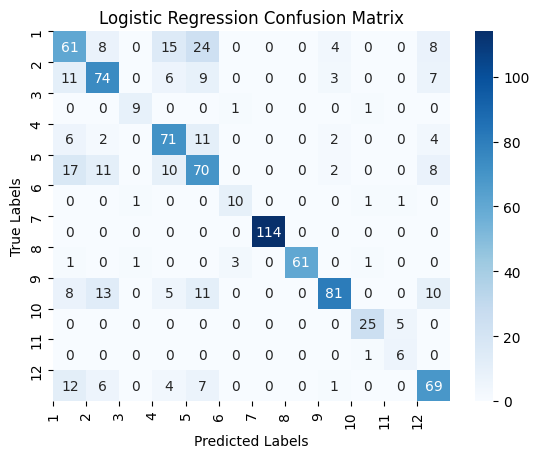

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have a trained logistic regression model named 'logreg_model'
logreg_model = LogisticRegression(C=1, class_weight='balanced', penalty= 'l2', solver= 'liblinear')

# Assuming X_train and y_train are your training data
logreg_model.fit(Train_X_Tfidf, y_train_encoded)

# Save model
filename = 'logistic_regression_best_model.h5'
model.save(filename)

# Make predictions on X_test
y_pred_encoded = logreg_model.predict(Test_X_Tfidf)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)


# Generar la matriz de confusión
confusion_matrix_lr = confusion_matrix(y_test, y_pred)

# Graficar
sns.heatmap(confusion_matrix_lr, annot=True, cmap='Blues', fmt='d')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression Confusion Matrix')
plt.xticks(ticks=np.arange(num_classes), labels=range(1,num_classes + 1), rotation=90)
plt.yticks(ticks=np.arange(num_classes), labels=range(1,num_classes + 1))

## Random Forest

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Create a Random Forest classifier
rf_model = RandomForestClassifier()

# Define the parameter grid to search
param_grid = {
    'n_estimators': [10, 20, 50],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(Train_X_Tfidf, y_train_encoded)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_encoded = best_model.predict(Test_X_Tfidf)

# Decode predictions back to original labels if needed
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.6944140197152245
Classification Report:
                 precision    recall  f1-score   support

      business       0.58      0.50      0.54       120
        comedy       0.68      0.59      0.63       110
      contacto       0.82      0.82      0.82        11
  food & drink       0.53      0.74      0.62        96
healthy living       0.44      0.64      0.52       118
        inicio       0.83      0.77      0.80        13
       literal       1.00      1.00      1.00       114
         login       1.00      0.93      0.96        67
  queer voices       0.84      0.59      0.70       128
      registro       0.85      0.93      0.89        30
     seguridad       0.78      1.00      0.88         7
        sports       0.73      0.58      0.64        99

      accuracy                           0.69       913
     macro avg       0.76      0.76      0.75       913


Accuracy: 0.6845564074479737
Classification Report:
                 precision    recall  f1-score   support

      business       0.54      0.48      0.51       120
        comedy       0.68      0.60      0.64       110
      contacto       0.82      0.82      0.82        11
  food & drink       0.51      0.72      0.60        96
healthy living       0.45      0.62      0.52       118
        inicio       0.77      0.77      0.77        13
       literal       1.00      1.00      1.00       114
         login       1.00      0.93      0.96        67
  queer voices       0.83      0.56      0.67       128
      registro       0.88      0.93      0.90        30
     seguridad       0.67      0.86      0.75         7
        sports       0.70      0.59      0.64        99

      accuracy                           0.68       913
     macro avg       0.74      0.74      0.73       913
  weighted avg       0.71      0.68      0.69       913



([<matplotlib.axis.YTick at 0x7a30b0348880>,
 [Text(0, 0, '1'),
  Text(0, 1, '2'),
  Text(0, 2, '3'),
  Text(0, 3, '4'),
  Text(0, 4, '5'),
  Text(0, 5, '6'),
  Text(0, 6, '7'),
  Text(0, 7, '8'),
  Text(0, 8, '9'),
  Text(0, 9, '10'),
  Text(0, 10, '11'),
  Text(0, 11, '12')])

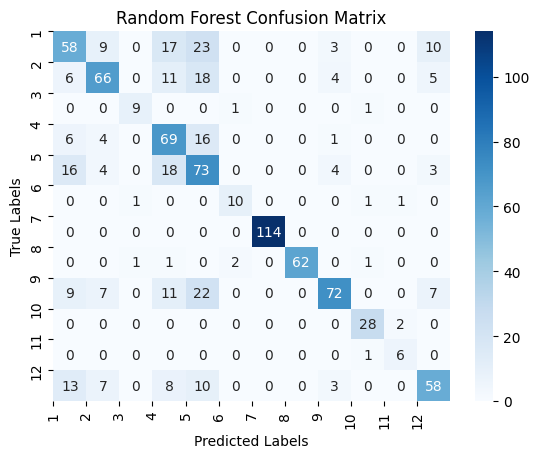

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Assuming X_train and y_train_encoded are your training data
rf_model = RandomForestClassifier(max_depth = None, 
                                  min_samples_leaf = 1,
                                  min_samples_split = 10, 
                                  n_estimators=50, 
                                  random_state=42)
rf_model.fit(Train_X_Tfidf, y_train_encoded)

# Assuming X_test is your test data
y_pred_encoded = rf_model.predict(Test_X_Tfidf)

# Decode predictions back to original labels if needed
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

# Generar la matriz de confusión
confusion_matrix_rf = confusion_matrix(y_test, y_pred)

# Graficar
sns.heatmap(confusion_matrix_rf, annot=True, cmap='Blues', fmt='d')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Random Forest Confusion Matrix')
plt.xticks(ticks=np.arange(num_classes), labels=range(1,num_classes + 1), rotation=90)
plt.yticks(ticks=np.arange(num_classes), labels=range(1,num_classes + 1))

## Support Vector Machine

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the SVM model
svm_model = SVC()

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],               # Regularization parameter
    'kernel': ['linear', 'rbf'],     # Kernel type
    'gamma': ['scale', 'auto'],      # Kernel coefficient for 'rbf'
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=svm_model,
                           param_grid=param_grid,
                           cv=3,
                           scoring='accuracy',
                           verbose=10)

# Fit the model to the training data
grid_search.fit(Train_X_Tfidf, y_train_encoded)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(Test_X_Tfidf)


# Decode predicted labels if needed
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Best Parameters:", best_params)
print("Accuracy:", accuracy)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START C=0.1, gamma=scale, kernel=linear..........................
[CV 1/3; 1/12] END C=0.1, gamma=scale, kernel=linear;, score=0.515 total time=   1.0s
[CV 2/3; 1/12] START C=0.1, gamma=scale, kernel=linear..........................
[CV 2/3; 1/12] END C=0.1, gamma=scale, kernel=linear;, score=0.500 total time=   1.0s
[CV 3/3; 1/12] START C=0.1, gamma=scale, kernel=linear..........................
[CV 3/3; 1/12] END C=0.1, gamma=scale, kernel=linear;, score=0.510 total time=   1.0s
[CV 1/3; 2/12] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 1/3; 2/12] END C=0.1, gamma=scale, kernel=rbf;, score=0.320 total time=   1.3s
[CV 2/3; 2/12] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 2/3; 2/12] END C=0.1, gamma=scale, kernel=rbf;, score=0.323 total time=   1.3s
[CV 3/3; 2/12] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 3/3; 2/12] END C=0.1, gam

SVM Accuracy Score ->  0.6955093099671413
Accuracy: 0.6955093099671413
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.47      0.53       159
           1       0.58      0.71      0.64        90
           2       0.82      0.82      0.82        11
           3       0.69      0.63      0.66       104
           4       0.58      0.45      0.51       152
           5       0.77      0.83      0.80        12
           6       1.00      1.00      1.00       114
           7       0.93      1.00      0.96        62
           8       0.59      0.87      0.71        87
           9       0.83      0.86      0.85        29
          10       0.86      0.60      0.71        10
          11       0.61      0.72      0.66        83

    accuracy                           0.70       913
   macro avg       0.74      0.75      0.74       913
weighted avg       0.70      0.70      0.69       913



([<matplotlib.axis.YTick at 0x7a300c607a00>,
 [Text(0, 0, '1'),
  Text(0, 1, '2'),
  Text(0, 2, '3'),
  Text(0, 3, '4'),
  Text(0, 4, '5'),
  Text(0, 5, '6'),
  Text(0, 6, '7'),
  Text(0, 7, '8'),
  Text(0, 8, '9'),
  Text(0, 9, '10'),
  Text(0, 10, '11'),
  Text(0, 11, '12')])

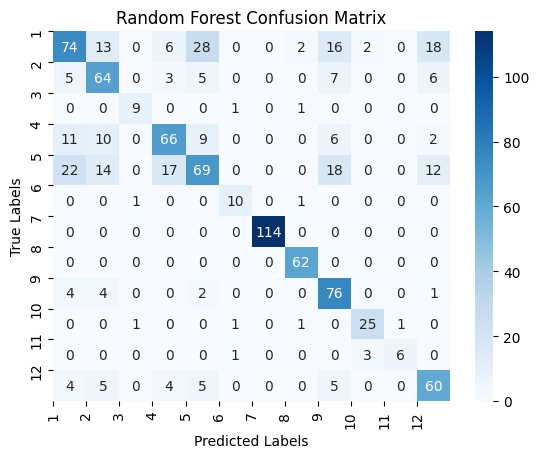

In [25]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
from sklearn.svm import SVC

SVM = SVC(C=1, kernel='rbf', gamma='scale')
SVM.fit(Train_X_Tfidf, y_train_encoded)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test_encoded))

# Evaluate the model
accuracy = accuracy_score(predictions_SVM, y_test_encoded)

classification_rep = classification_report(predictions_SVM, y_test_encoded )

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

# Generar la matriz de confusión
confusion_matrix_rf = confusion_matrix(predictions_SVM, y_test_encoded)

# Graficar
sns.heatmap(confusion_matrix_rf, annot=True, cmap='Blues', fmt='d')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Random Forest Confusion Matrix')
plt.xticks(ticks=np.arange(num_classes), labels=range(1,num_classes + 1), rotation=90)
plt.yticks(ticks=np.arange(num_classes), labels=range(1,num_classes + 1))